### Task 4: Target Engineering 

In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Step 2: Load the Raw Data
df = pd.read_csv('../data/raw/data.csv')
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [3]:
#Step 3: Define Snapshot Date 
# Convert transaction time column
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Set snapshot date (usually max + 1 day)
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)
print(f"Snapshot Date: {snapshot_date.date()}")


Snapshot Date: 2019-02-14


In [4]:
# Step 4: Calculate RFM Features
rfm_df = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,
    'TransactionId': 'count',
    'Amount': 'sum'
}).reset_index()

rfm_df.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary']
rfm_df.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


In [5]:
# Step 5: Scale the RFM Data

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])


In [6]:
# Step 6: Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)


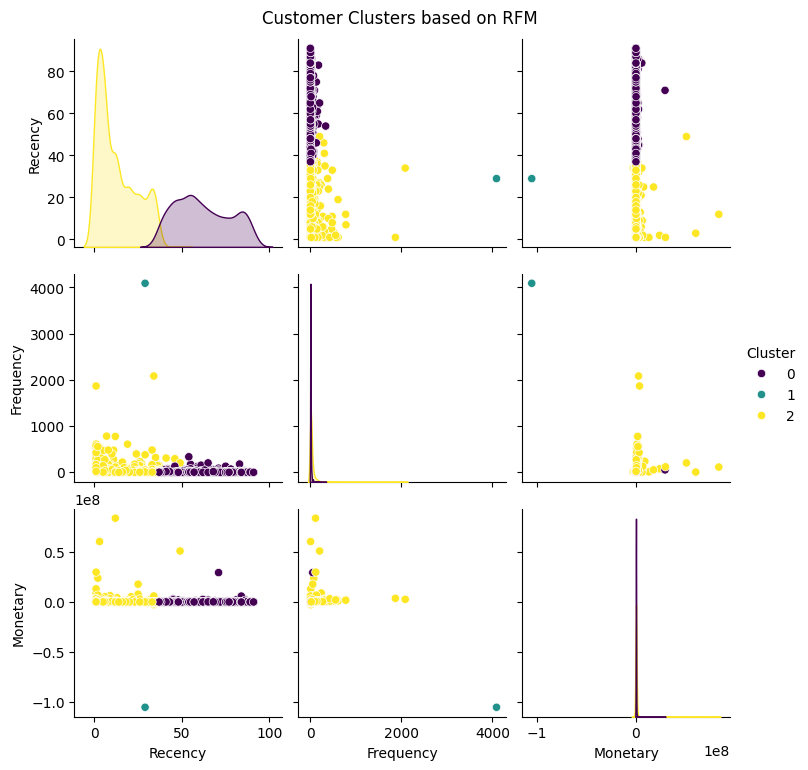

In [7]:
# Step 7: Visualize Clusters
sns.pairplot(rfm_df, hue='Cluster', palette='viridis')
plt.suptitle('Customer Clusters based on RFM', y=1.02)
plt.show()


In [8]:
# Step 8: Identify the High-Risk Cluster
# Rank clusters by risk (adjust based on actual values)
cluster_stats = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_stats)


   Cluster    Recency    Frequency      Monetary
0        0  61.859846     7.726699  8.172379e+04
1        1  29.000000  4091.000000 -1.049000e+08
2        2  12.716076    34.807692  2.726546e+05


In [9]:
# Suppose cluster 1 is high risk (change based on output above)
high_risk_cluster = cluster_stats.sort_values(by=['Recency', 'Frequency', 'Monetary'], ascending=[False, True, True]).iloc[0]['Cluster']

rfm_df['is_high_risk'] = (rfm_df['Cluster'] == high_risk_cluster).astype(int)


In [10]:
# Step 9: Merge is_high_risk Back to Main Data
# Save or merge
df_merged = df.merge(rfm_df[['CustomerId', 'is_high_risk']], on='CustomerId', how='left')

df_merged.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,is_high_risk
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0,0


In [11]:
# Step 10: Save Processed Data
df_merged.to_csv('../data/processed/data_with_risk.csv', index=False)
